In [96]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
def tsne_by_gender(vecs, labels, title):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)

  names = ["class 1", "class 2"]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b'
  for i, c, label in zip(range(10), colors, names):
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c, label=label, alpha = 0.2)
  plt.legend()
  plt.title(title)
  plt.show()
  return vecs_2d

### Data loading & processing

In [230]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors):
    
    group1 = model.similar_by_vector(gender_vector, topn = 3000, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = 3000, restrict_vocab=None)
    
    return group1, group2

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)
    return vecs


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [231]:
model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")
model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")
gender_direction = model_gendered["he"] - model_gendered["she"]
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)

#gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])

masc_words_and_scores, fem_words_and_scores = project_on_gender_subspaces(gender_direction, model)
masc_words, masc_scores = list(zip(*masc_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)

print(masc_words[:25])
print(masc_words[-10:])
print("-------------------------")
print(fem_words[:25])
print(fem_words[-10:])

('journeyman', 'elder_statesman', 'fellow_countryman', 'endeared_himself', 'cult_hero', 'journeymen', 'swashbuckling', 'distanced_himself', 'prodigal_son', 'tradeable', 'prides_himself', 'hero', 'heir_apparent', 'elder_statesmen', 'benching', 'successor', 'burly', 'serviceable', 'jnr', 'goatee', 'league', 'training_camp', 'maestro', 'legendary', 'positional')
('audio', 'twice', 'testicles', 'silenced', 'luring', 'appeasing', 'career_multihomer', 'groin_muscle', 'archenemy', 'contemporaries')
-------------------------
('alumna', 'beautician', 'motherly', 'petite', 'comedienne', 'saleswoman', 'songstress', 'ditzy', 'mommies', 'lip_gloss', 'perky', 'girlish', 'homemaker', 'bra', 'femininity', 'chanteuse', 'mums', 'pregnant', 'vivacious', 'breastfeeding', 'registered_nurse', 'catty', 'seamstress', 'tiara', 'spinster')
('cloths', 'cooks', 'prosthesis', 'pneumatic', 'disability', 'melons', 'lunches', 'goody', 'doctoral_student', 'mattress')


### Perform train-dev-test split

In [232]:
X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
print(X.shape)
y_masc = np.zeros(masc_vecs.shape[0], dtype = int)
y_fem = np.ones(fem_vecs.shape[0], dtype = int)
y = np.concatenate((y_masc, y_fem))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

(6000, 300)
Train size: 2520; Dev size: 1080; Test size: 2400


### Debias

In [233]:
classifier_class = svm_classifier.SVMClassifier
num_classifiers = 40
input_dim = 300
is_autoregressive = True
min_accuracy = 0.5
add_noise = False
random_projection = False

P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise, random_projection)

Iteration 0, Accuracy: 1.0
Iteration 1, Accuracy: 0.8870370370370371
Iteration 2, Accuracy: 0.8388888888888889
Iteration 3, Accuracy: 0.7685185185185185
Iteration 4, Accuracy: 0.7240740740740741
Iteration 5, Accuracy: 0.6768518518518518
Iteration 6, Accuracy: 0.6296296296296297
Iteration 7, Accuracy: 0.5898148148148148
Iteration 8, Accuracy: 0.5648148148148148
Iteration 9, Accuracy: 0.5148148148148148
Iteration 10, Accuracy: 0.5175925925925926
Iteration 11, Accuracy: 0.5083333333333333
Iteration 12, Accuracy: 0.49444444444444446
Iteration 13, Accuracy: 0.49444444444444446
Iteration 14, Accuracy: 0.49444444444444446
Iteration 15, Accuracy: 0.49444444444444446
Iteration 16, Accuracy: 0.49444444444444446
Iteration 17, Accuracy: 0.49444444444444446
Iteration 18, Accuracy: 0.49444444444444446
Iteration 19, Accuracy: 0.49444444444444446
Iteration 20, Accuracy: 0.49444444444444446
Iteration 21, Accuracy: 0.49444444444444446
Iteration 22, Accuracy: 0.49444444444444446
Iteration 23, Accuracy: 0

### Test the quality of the debiasing.

#### Perform t-sne

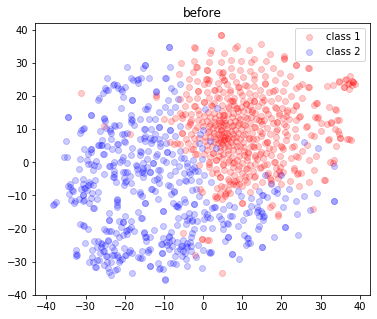

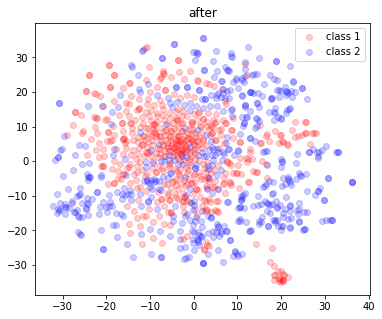

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

Purity in original space: 0.8068166361244357
Purity after debiasing projection: 0.49825314099477575


In [234]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score


tsne_by_gender(X_dev, Y_dev, title = "before")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
tsne_projection = tsne_by_gender(X_dev_cleaned, Y_dev, title = "after")

NUM_CLUSTERS = 100

purity_original = perform_purity_test(X_dev, k = NUM_CLUSTERS, labels_true = Y_dev)
purity_after = perform_purity_test(X_dev_cleaned, k = NUM_CLUSTERS, labels_true = Y_dev)
print("Purity in original space: {}".format(purity_original))
print("Purity after debiasing projection: {}".format(purity_after))

#### Train a nonlinear classifier for gender prediction.

In [235]:
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf = SGDClassifier(loss = "modified_huber", verbose = 0, max_iter = 5000, fit_intercept = True, class_weight = "balanced", penalty = "l2")
print("Before:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before:


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0
After:


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5972222222222222


#### project on the gender direction

In [236]:

masc_vecs_cleaned = masc_vecs.dot(P)
fem_vecs_cleaned = fem_vecs.dot(P)

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec).mean()))      

masc-bias-before: 0.37643688917160034
masc-bias-after: -0.0596740290059727
fem-bias-before: -0.6394068002700806
fem-bias-after: -0.07388504183779382


#### calculate the similarity matrix before and after

In [237]:

def get_distance_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_distance(distance_before, distance_after):

    idx = distance_before < 0.75 # we are only interested in the relatively close words

    print(distance_before.shape, distance_after.shape, idx.shape)
    distance_before = distance_before.copy()[idx]
    distance_after = distance_after.copy()[idx]
    
    chosen = np.random.rand(len(distance_before)) < 0.01
    before = distance_before[chosen]
    after = distance_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("distnace before")
    plt.ylabel("distance after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after):

    K = 50
    most_similar_idx_before = distance_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = distance_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, dis_before, dis_after) in enumerate(tqdm.tqdm(zip(bias_before, distance_before, distance_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = (most_similar_idx_before[i] == most_similar_idx_after[i]).sum() 
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        #data.append((abs(bias), 1 - intersection/K))
        
    plt.xlabel("change in similarity (% of of top-{}-similar that changed)".format(K))
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

#### Plot similarity before vs. similarity after, and change of similarity vs. bias before

(9757, 9757) (9757, 9757)
(95199049,) (95199049,) (95199049,)


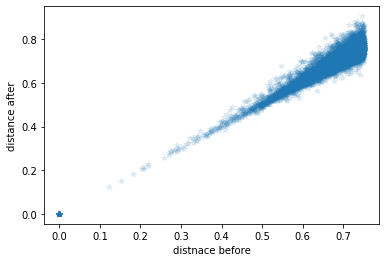

Correlation: 0.9657959582132298


100%|##########| 9757/9757 [00:00<00:00, 59115.15it/s]


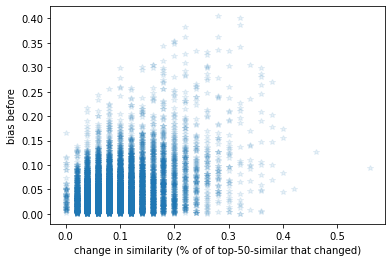

Correlation: 0.3389137243341658


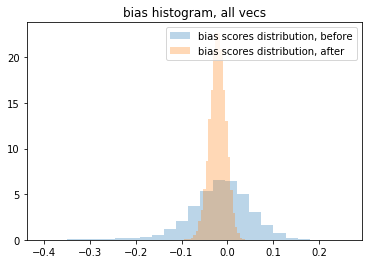

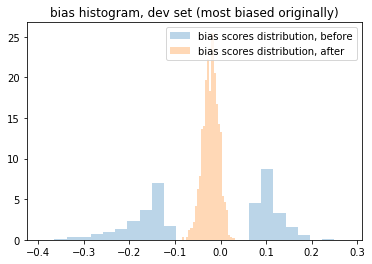

In [240]:
prop = 0.2
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
words_sample = np.array(words, dtype = "object")[idx]

vecs_sample_cleaned = vecs_sample.dot(P)

distance_before = get_distance_matrix(vecs_sample)
distance_after = get_distance_matrix(vecs_sample_cleaned)
print(distance_before.shape, distance_after.shape)
#diffs = abs(similarity_before - similarity_after)


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample)[0] #sample_normalized.dot(gender_unit_vec)
bias_after = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample_cleaned)[0] #sample_normalized.dot(gender_unit_vec)

plot_distance(distance_before.reshape(-1), distance_after.reshape(-1))
plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after)

# plot bias histograms before and after

# all vecs

plt.hist(bias_before, bins = 25, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after, bins = 25, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, all vecs")
plt.show()

# most originally biases (dev set)

bias_before_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev)[0]
bias_after_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev.dot(P))[0]

plt.hist(bias_before_dev, bins = 25, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after_dev, bins = 25, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, dev set (most biased originally)")
plt.show()


In [220]:
all_cleaned = vecs.dot(P)
save_in_word2vec_format(all_cleaned, words, "../data/embeddings/vecs.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.cleaned.txt")

50000it [00:12, 3918.84it/s]


In [221]:
w = "midwife"
male_gendered_professions = ["builder", "worker"]
topn = 15

for w_sim in male_gendered_professions:
    print(model.similarity(w, w_sim), model_cleaned.similarity(w, w_sim)) 
    
print("---------------------------------------------")

0.20190004 0.16835478
0.3137167 0.21459472
---------------------------------------------


In [241]:
w = "girlish"
topn = 15

for w_sim in model.most_similar(w, topn = topn):
    print(w_sim)
print("--------------------------------")
for w_sim in model_cleaned.most_similar(w, topn = topn):
    print(w_sim)
    
for w_sim in ['alumna', 'comedienne', 'beautician', 'femininity', 'chanteuse', 'petite', 'songstress', 'girlish', 'saleswoman', 'homemaker', 'showgirl', 'lipsticks', 'ditzy', 'demure', 'bra', 'lip_gloss', 'vivacious', 'hysterectomy', 'perky', 'femme_fatale', 'double_mastectomy', 'spinster', 'registered_nurse', 'sassy', 'motherly']:
    print(model.similarity(w, w_sim) -  model_cleaned.similarity(w, w_sim)) 
print("------------------------------------------")
for w_sim in ['journeyman', 'elder_statesman', 'fellow_countryman', 'journeymen', 'cult_hero', 'wizard', 'knucklehead', 'prodigal_son', 'guys', 'buddy']:
    print(model.similarity(w, w_sim) -  model_cleaned.similarity(w, w_sim))

('childlike', 0.6296223998069763)
('ladylike', 0.6225330233573914)
('girly', 0.6093579530715942)
('feminine', 0.6053792238235474)
('winsome', 0.5993518233299255)
('demure', 0.5930185317993164)
('sassy', 0.5879800915718079)
('perky', 0.5804826021194458)
('androgynous', 0.577804446220398)
('boyish', 0.5753630995750427)
('giggly', 0.5665026307106018)
('dainty', 0.5623782873153687)
('femininity', 0.5611006617546082)
('flirtatious', 0.5558633208274841)
('breathy', 0.5549523234367371)
--------------------------------
('boyish', 0.5512911081314087)
('childlike', 0.5243393182754517)
('winsome', 0.4430544674396515)
('impish', 0.44183504581451416)
('feminine', 0.4399568736553192)
('youthful', 0.43680235743522644)
('playfulness', 0.4328940510749817)
('girly', 0.43216490745544434)
('esque', 0.4274441599845886)
('wispy', 0.4214945435523987)
('wistful', 0.4141550660133362)
('jaunty', 0.41312459111213684)
('androgynous', 0.4040895998477936)
('ladylike', 0.4014776349067688)
('steely', 0.39312487840652